# Survival analysis for liver values

In [1]:
import ehrapy as ep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rich import print

/home/zeth/miniconda3/envs/ehrapy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ep.settings.set_figure_params(dpi=150)

In [3]:
adata = ep.io.read_h5ad(
    "../anndata_objects/adata_pneumonia_unspecified_rest_annotated.h5ad"
)
adata

AnnData object with n_obs × n_vars = 277 × 254
    obs: ' Dexmedetomidine Hydrochloride Injection', '(4:1)Glucose and Sodium Chloride Injection', '0.9% Sodium Chloride Injection', '10% Calcium Gluconate Injection', '10% Chloral Hydrate Enemas', '10% Chloral Hydrate Syrup', '10% Glucose Injection', '10% Potassium Chloride Injection', '10% Potassium Chloride Oral Solution', '10% Sodium Chloride Injection', '20% Albumin Prepared From Human Plasma Injection', '20% Mannitol Injection', '20% Medium and Long Chain Fat Emulsion Injection', '25% Magnesium Sulfate Injection', '5% Amino Acidi Injection', '5% Calcium Chloride Injection', '5% Glucose Injection', '5% Glucose and Sodium Chloride Injection', '5% Sodium Bicarbonate Injection', '50% Glucose Injection', '6% Dextran 40 Glucose Injection', 'Aciclovir for Injection', 'Ademetionine  1,4-Butanedisulfonate for Injection', 'Adrenaline Hydrochlaride Injection', 'Alprostadil Injection', 'Ambroxol Hydrochloride Injection', 'Ambroxol Hydrochloride 

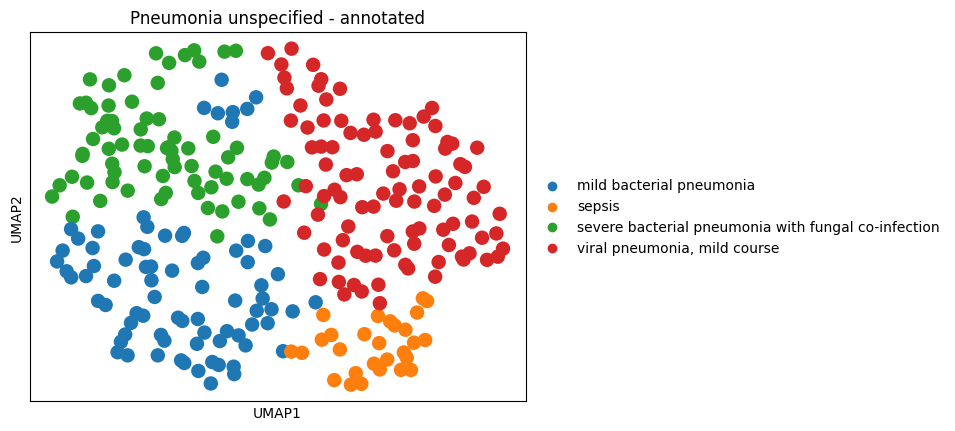

In [4]:
ep.pl.umap(adata, color=["Pneumonia unspecified - annotated"])

## Data preparation

In [5]:
adata.obs["gender_num"] = adata.obs["gender"].cat.rename_categories({"F": 0, "M": 1})

Filter the AnnData object by time. We only want to keep patients that stayed for less than 10 days.

In [6]:
adata.obs["OUTTIME"] = pd.to_datetime(adata.obs["OUTTIME"])
adata.obs["INTIME"] = pd.to_datetime(adata.obs["INTIME"])
hours_diff = (adata.obs["OUTTIME"] - adata.obs["INTIME"]).dt.total_seconds() / 3600
adata.obs["STAY_TIME_HOURS"] = hours_diff

mask = hours_diff < 240
filtered_adata = adata[mask]
filtered_adata

View of AnnData object with n_obs × n_vars = 172 × 254
    obs: ' Dexmedetomidine Hydrochloride Injection', '(4:1)Glucose and Sodium Chloride Injection', '0.9% Sodium Chloride Injection', '10% Calcium Gluconate Injection', '10% Chloral Hydrate Enemas', '10% Chloral Hydrate Syrup', '10% Glucose Injection', '10% Potassium Chloride Injection', '10% Potassium Chloride Oral Solution', '10% Sodium Chloride Injection', '20% Albumin Prepared From Human Plasma Injection', '20% Mannitol Injection', '20% Medium and Long Chain Fat Emulsion Injection', '25% Magnesium Sulfate Injection', '5% Amino Acidi Injection', '5% Calcium Chloride Injection', '5% Glucose Injection', '5% Glucose and Sodium Chloride Injection', '5% Sodium Bicarbonate Injection', '50% Glucose Injection', '6% Dextran 40 Glucose Injection', 'Aciclovir for Injection', 'Ademetionine  1,4-Butanedisulfonate for Injection', 'Adrenaline Hydrochlaride Injection', 'Alprostadil Injection', 'Ambroxol Hydrochloride Injection', 'Ambroxol Hydroc

In [7]:
norm_ranges = {}
norm_ranges["AST"] = [10, 40]
norm_ranges["ALT"] = [10, 35]
norm_ranges["bilirubin"] = [0.2, 1.2]
norm_ranges["gGT"] = [0, 35]
norm_ranges["prealbumin"] = [15, 35]
norm_ranges["albumin"] = [35, 55]


def norm_values(measurements, lab_value, norm_ranges):
    """0 if the value is in the norm range, 1 elsewise"""
    norm_array = [
        0 if norm_ranges[lab_value][0] <= measurement <= norm_ranges[lab_value][1] else 1
        for measurement in measurements
    ]

    return np.array(norm_array)

In [8]:
def get_norm_values(adata, norm_ranges):
    bilirubin_norm = norm_values(
        adata[:, "Bilirubin, Direct_max"].layers["original_imputed"], "bilirubin", norm_ranges
    )
    g_glutamyltransferase_norm = norm_values(
        adata[:, "Gamma Glutamyltransferase_max"].layers["original_imputed"], "gGT", norm_ranges
    )
    albumin_norm = norm_values(
        adata[:, "Albumin_min"].layers["original_imputed"], "albumin", norm_ranges
    )
    alt_norm = norm_values(
        adata[:, "Alanine Aminotransferase (ALT)_max"].layers["original_imputed"], "ALT", norm_ranges
    )
    ast_norm = norm_values(
        adata[:, "Asparate Aminotransferase (AST)_max"].layers["original_imputed"],
        "AST",
        norm_ranges
    )
    joint_alt_ast = np.logical_or(alt_norm, ast_norm).astype(int)

    all_norm_values = {
#        "Albumin": albumin_norm,
#        "Bilirubin": bilirubin_norm,
        "Gamma Glutamyltransferase": g_glutamyltransferase_norm,
        "ALT": alt_norm,
        "AST": ast_norm,
     #   "Joint ALT AST": joint_alt_ast,
    }

    return all_norm_values

In [15]:
def kmf_statistics_plot(adata, xlim=(0, 500)):
    all_norm_values = get_norm_values(adata, norm_ranges)

    for name, measurement in all_norm_values.items():
        T = np.array(adata.obs.STAY_TIME_HOURS)  # should be in days -> recalculate it
        E = adata[:, ["ehrapycat_Death_1"]].X
        groups = measurement
        ix1 = groups == 0
        ix2 = groups == 1
        kmf_1 = ep.tl.kmf(T[ix1], E[ix1], label=f"Inside {name} Norm")
        kmf_2 = ep.tl.kmf(T[ix2], E[ix2], label=f"Outside {name} Norm")

        log_rank_test_result = ep.tl.test_kmf_logrank(kmf_1, kmf_2)
        print(f"[bold blue]Test results for {name} for {len(adata.obs)} patients:")
        print(f"p-value of {log_rank_test_result.p_value:2f}")
        if log_rank_test_result.p_value < 0.05:
            print("[bold red]SIGNIFICANT")

        ep.pl.kmf(
            [kmf_1, kmf_2],
            color=["k", "r"],
            xlim=xlim,
            ylim=[0, 1],
            xlabel="Hours",
            ylabel="Proportion Who Survived",
            show=True,
        )

        output_dir = Path("./kaplan_meier")
        output_dir.mkdir(parents=True, exist_ok=True)
        plt.savefig(f"{output_dir}/kmf_{name}_{len(adata.obs)}.png")

## Kaplan Meier for all patients jointly

Test results for Gamma Glutamyltransferase for 277 patients:

p-value of 0.724551

Test results for ALT for 277 patients:

p-value of 0.294934

Test results for AST for 277 patients:

p-value of 0.025814

SIGNIFICANT

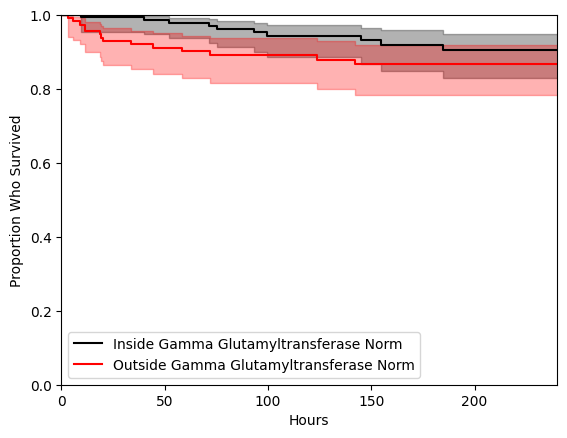

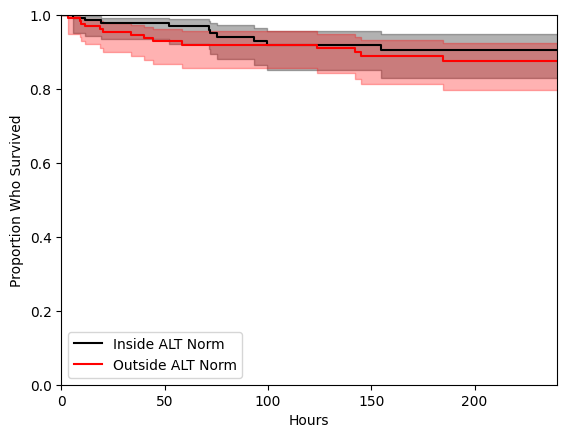

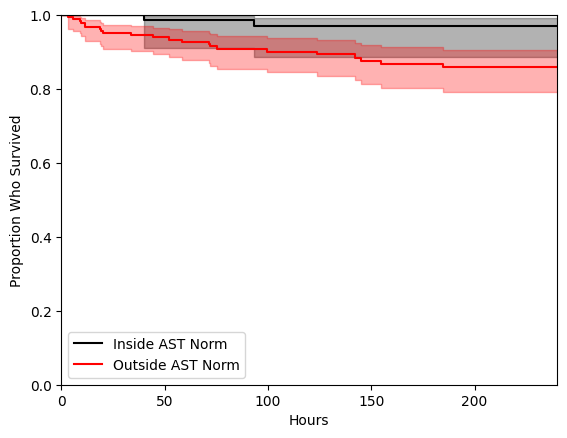

In [16]:
kmf_statistics_plot(adata, xlim=(0, 240))

Test results for Gamma Glutamyltransferase for 172 patients:

p-value of 0.004201

SIGNIFICANT

Test results for ALT for 172 patients:

p-value of 0.023887

SIGNIFICANT

Test results for AST for 172 patients:

p-value of 0.001353

SIGNIFICANT

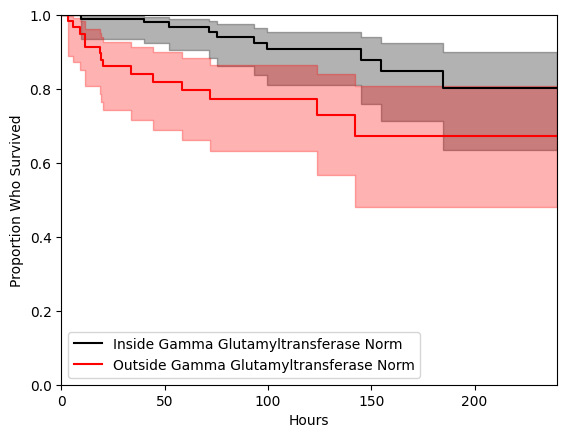

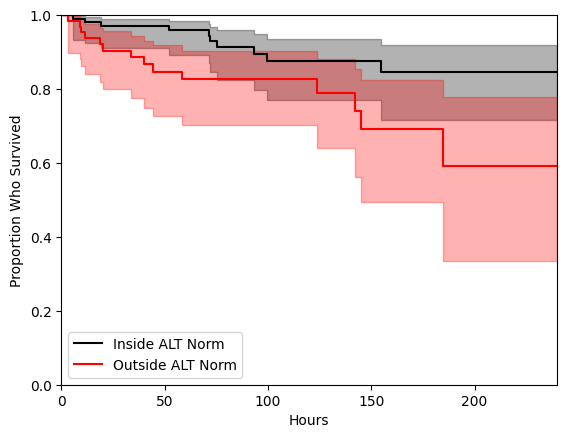

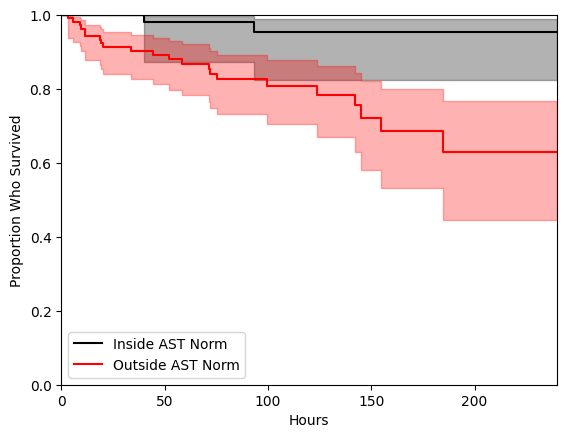

In [17]:
kmf_statistics_plot(filtered_adata, xlim=(0, 240))

## Kaplan Meier per group separately

In [ ]:
for group in list(adata.obs["Pneumonia unspecified - annotated"].unique()):
    adata_group = adata[adata.obs["Pneumonia unspecified - annotated"] == group]
    print(group)
    kmf_statistics_plot(adata_group, xlim=(0, 240))
    print()

In [ ]:
for group in list(adata.obs["Pneumonia unspecified - annotated"].unique()):
    adata_group = filtered_adata[filtered_adata.obs["Pneumonia unspecified - annotated"] == group]
    print(group)
    kmf_statistics_plot(adata_group, xlim=(0, 240))
    print()